In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [3]:
credit = pd.read_csv('./uci_credit_card.csv')

In [17]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Hyperparameters and Parameters

## Extracting a Logistic Regression parameter

In [18]:
print(credit.shape)
credit.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [21]:
X = credit.loc[:, 'LIMIT_BAL':'PAY_AMT6']
X = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)
y = credit['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1111)

In [23]:
# instantiate log reg and fit
log_reg_clf = LogisticRegression()

log_reg_clf.fit(X_train, y_train)

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [29]:
# Create a list of original variable names from the training DataFrame
original_variables = list(X_train.columns)

# Extract the coefficients of the logistic regression estimator
model_coefficients = log_reg_clf.coef_[0]

# Create a dataframe of the variables and coefficients & print it out
coefficient_df = pd.DataFrame({'Variable' : original_variables,
                               'Coefficient': model_coefficients})

# Print out the top 3 positive variables
top_df = coefficient_df.sort_values(by='Coefficient', axis=0, ascending=False)
top_df.head(3)

,Variable,Coefficient
12,BILL_AMT5,0.000006
9,BILL_AMT2,0.000005
2,PAY_0,0.000004


## Extracting a Random Forest parameter

In [31]:
rf_clf = RandomForestClassifier(random_state=1111)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=1111)

In [33]:
# Extract the 7th (index 6) tree from the random forest
chosen_tree = rf_clf.estimators_[6]

# Extract the parameters and level of the top (index 0) node
split_column = chosen_tree.tree_.feature[0]
split_column_name = X_train.columns[split_column]
split_value = chosen_tree.tree_.threshold[0]

# Print out the feature and level
print(f'This node split on feature {split_column_name}, at a value of {split_value}')

This node split on feature PAY_AMT2, at a value of 149.0


# Introducing Hyperparameters

## Exploring Random Forest Hyperparameters

In [42]:
rf_old_preds = rf_clf.predict(X_test)

# print out the old estimator, notice hyperparameters is badly set
print(rf_clf.get_params())

# get conf matrix & accuracy for the old rf_model
print(f'\nConfusion matrix:\n{confusion_matrix(y_test, rf_old_preds)}')
print(f'Test acc: {accuracy_score(y_test, rf_old_preds): .1%}')

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1111, 'verbose': 0, 'warm_start': False}

Confusion matrix:
[[6622  387]
 [1259  732]]
Test acc:  81.7%


In [43]:
# create a new random forest with 500 trees
rf_clf_new = RandomForestClassifier(n_estimators=500,
                                    random_state=1111)

rf_clf_new.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1111)

In [44]:
rf_new_preds = rf_clf_new.predict(X_test)

# get conf matrix & accuracy for the new rf_model
print(f'\nConfusion matrix:\n{confusion_matrix(y_test, rf_new_preds)}')
print(f'Test acc: {accuracy_score(y_test, rf_new_preds): .1%}')


Confusion matrix:
[[6616  393]
 [1245  746]]
Test acc:  81.8%


## Hyperparameters of KNN

In [46]:
# Build a knn estimator for each value of n_neighbours
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn_20 = KNeighborsClassifier(n_neighbors=20)

# Fit each to the training data & produce predictions
knn_5_predictions = knn_5.fit(X_train, y_train).predict(X_test)
knn_10_predictions = knn_10.fit(X_train, y_train).predict(X_test)
knn_20_predictions = knn_20.fit(X_train, y_train).predict(X_test)

# Get an accuracy score for each of the models
knn_5_accuracy = accuracy_score(y_test, knn_5_predictions)
knn_10_accuracy = accuracy_score(y_test, knn_10_predictions)
knn_20_accuracy = accuracy_score(y_test, knn_20_predictions)
print(f'The accuracy of 5, 10, 20 neighbours was {knn_5_accuracy: .1%}, {knn_10_accuracy: .1%}, {knn_20_accuracy: .1%}')

The accuracy of 5, 10, 20 neighbours was  75.4%,  77.6%,  77.9%


# Setting & Analyzing Hyperparameter Values

## Automating Hyperparameter Choice

In [48]:
# Set the learning rates & results storage
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
results_list = []

# Create the for loop to evaluate model predictions for each learning rate
for lr in learning_rates:
    model = GradientBoostingClassifier(learning_rate=lr)
    predictions = model.fit(X_train, y_train).predict(X_test)
    # Save the learning rate and accuracy score
    results_list.append([lr, accuracy_score(y_test, predictions)])

# Gather everything into a DataFrame
results_df = pd.DataFrame(results_list, columns=['learning_rate', 'accuracy'])
results_df

,learning_rate,accuracy
0,0.001,0.778778
1,0.010,0.819778
2,0.050,0.823667
3,0.100,0.822778
4,0.200,0.820667
5,0.500,0.811444


## Building Learning Curves

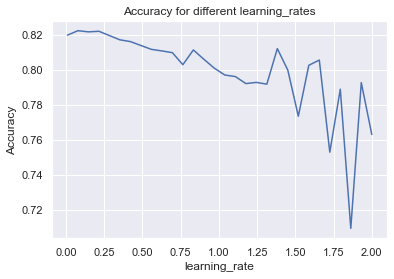

In [49]:
# Set the learning rates & accuracies list
learn_rates = np.linspace(0.01, 2, num=30)
accuracies = []

# Create the for loop
for learn_rate in learn_rates:
    # Create the model, predictions & save the accuracies as before
    model = GradientBoostingClassifier(learning_rate=learn_rate)
    predictions = model.fit(X_train, y_train).predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))

# Plot results    
plt.plot(learn_rates, accuracies)
plt.gca().set(xlabel='learning_rate', ylabel='Accuracy', title='Accuracy for different learning_rates')
plt.show()